In [22]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")
import os,sys
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import jaxley as jx

import sys
sys.path.append("../scripts/")

from Lyaponuv import  obtain_max_Lyapunov
from network import initialize_RNN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Network initialized

In [23]:
time_stamp = "0802-114242"

with open(f"../results/evint_init_params_{time_stamp}.pkl", "rb") as f:
    init_conn_matrix, init_input_weights, RNN_params = pickle.load(f)


In [24]:
RNN_params

{'RNN_seed': 3,
 'in_conn_prob': 1,
 'init_gain': 0.003141592653589793,
 'inp_scale': 0.1,
 'k_minus': 1,
 'n_inh': 10,
 'n_out': 2,
 'n_rec': 20,
 'out_conn_prob': 1,
 'out_k_minus': 0.025,
 'out_scale': 1,
 'rec_conn_prob': 0.2}

Init gain 0.003141592653589793


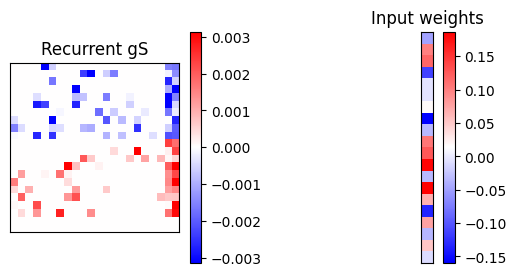

In [25]:
init_gain = RNN_params["init_gain"]
print(f"Init gain {init_gain}")

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
gS_rec = axs[0].matshow(init_conn_matrix, vmin=-init_gain, vmax=init_gain, cmap="bwr")
inp_ws = axs[1].matshow(init_input_weights[0]["input_weights"][:, np.newaxis], cmap="bwr")

axs[0].set_title("Recurrent gS")
plt.colorbar(gS_rec, ax=axs[0])
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_title("Input weights")
plt.colorbar(inp_ws, ax=axs[1])
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

In [26]:
with open(f"../results/evint_params_{time_stamp}.pkl", "rb") as f:
    params, task_params, RNN_params, train_params = pickle.load(f)

In [27]:
dt = 0.025
g_scaling = 100_000 / 2 / np.pi / 10.0 / 1.0
print(RNN_params['init_gain'])

0.003141592653589793


In [28]:
_ = np.random.seed(RNN_params['RNN_seed'])

network, init_conn_matrix, init_input_weights = initialize_RNN(RNN_params)

n_conns = len(np.nonzero(init_conn_matrix)[0])

3.45
69
20
conn probability recurrence: 0.17250000000000001
EIratio:1.0
Normaliser: 1.0598888663568604
Spectral radius recurrence: 0.0033942856019830285


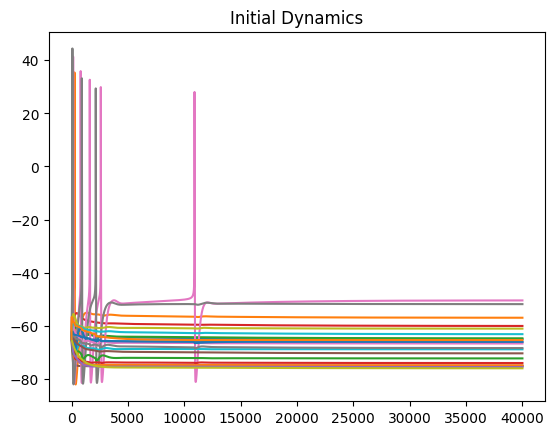

In [29]:
network.delete_recordings()
for i in range(len(network.cells)):
    network.cell([i]).branch(0).comp(0).record(verbose=False)

v = jx.integrate(network, t_max=1000)

plt.plot(v.T)
plt.title("Initial Dynamics")
plt.show()

In [30]:
n_models = 1
T = int(50000/dt)
transient = int(5000/dt)
renormalise_interval = 10/dt
verbose = False

L, Ls = obtain_max_Lyapunov(network, dt=dt, transient=transient, T=T, QR_t=renormalise_interval, verbose=verbose)
print("max Lyapunov exponent", L)


Added 109 recordings. See `.recordings` for details.
max Lyapunov exponent -1.015730479408095e-05


Text(0, 0.5, 'Lyapunov exponent')

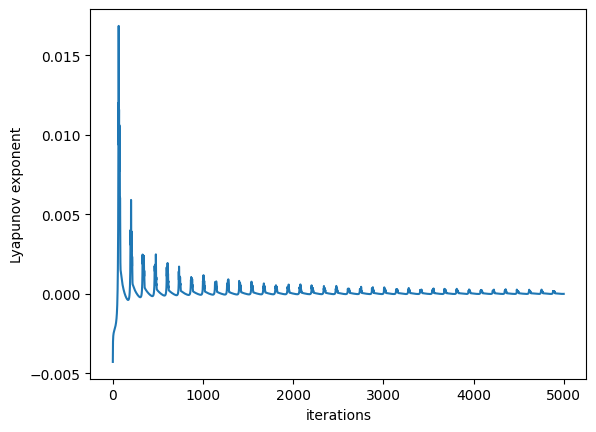

In [31]:
plt.plot(Ls[1:])
plt.xlabel("iterations")
plt.ylabel("Lyapunov exponent")

In [32]:
old_weights = []
for i in range(n_conns):
    old_weights.append(list(network.IonotropicSynapse(i).view['IonotropicSynapse_gS'])[0])

In [33]:
# Set trained parameters
network.delete_trainables()

for par in params:
    if "IonotropicSynapse_gS"in par.keys():
        for i, value in enumerate(par['IonotropicSynapse_gS']):
            network.IonotropicSynapse(i).set('IonotropicSynapse_gS', value)

    if "IonotropicSynapse_k_minus" in par.keys():
        for i,value in enumerate(par['IonotropicSynapse_k_minus']):
            network.IonotropicSynapse(i).set('IonotropicSynapse_k_minus', value)

In [34]:
new_weights = []
for i in range(n_conns):
   new_weights.append(list(network.IonotropicSynapse(i).view['IonotropicSynapse_gS'])[0])

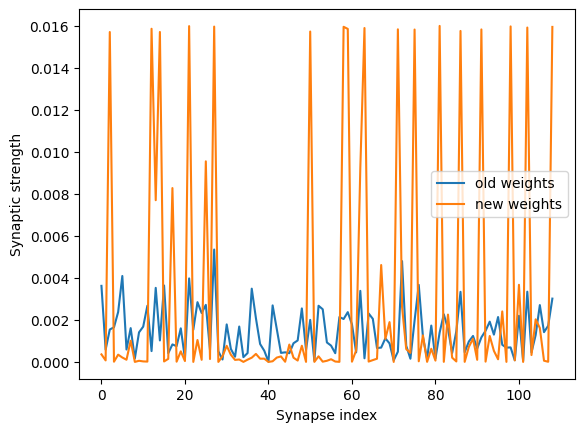

In [35]:
plt.plot(old_weights, label = "old weights")
plt.plot(new_weights, label = "new weights")
plt.xlabel("Synapse index")
plt.ylabel("Synaptic strength")
plt.legend()

In [36]:
n_models = 1
T = int(50000/dt)
transient=int(5000/dt)
renormalise_interval = 10/dt
verbose = False

L,Ls = obtain_max_Lyapunov(network,dt=dt,transient = transient,T=T,QR_t=renormalise_interval, verbose=verbose)
print("max Lyapunov exponent", L)

Added 109 recordings. See `.recordings` for details.
max Lyapunov exponent 0.0016898114622318561


Text(0, 0.5, 'Lyapunov exponent')

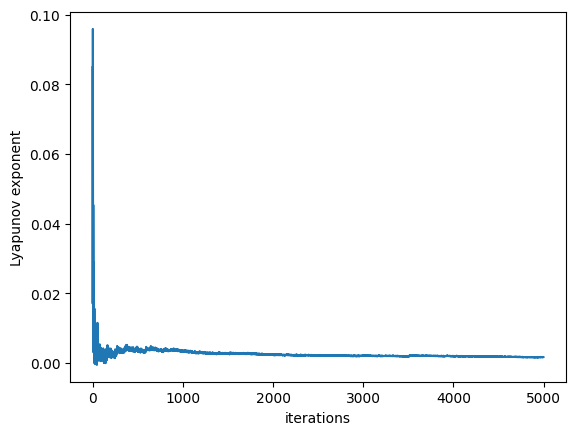

In [37]:
plt.plot(Ls[1:])
plt.xlabel("iterations")
plt.ylabel("Lyapunov exponent")

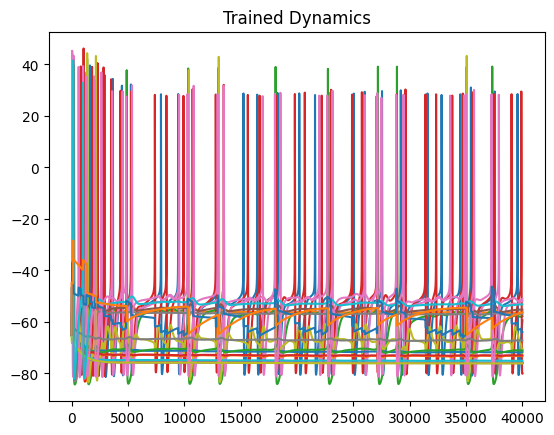

In [38]:
network.delete_recordings()
for i in range(len(network.cells)):
    network.cell([i]).branch(0).comp(0).record(verbose=False)

v = jx.integrate(network, t_max=1000)

plt.plot(v.T)
plt.title("Trained Dynamics")
plt.show()